<a href="https://colab.research.google.com/github/bridgetmanu/Decision-Trees-Neural-Networks/blob/main/Decision_Trees_%26_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR, BaggingRegressor as BR)
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import subplots
from tensorflow.keras.datasets import mnist, boston_housing
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping




#### Problem 1

In [ ]:
# Load the dataset
hitter = pd.read_csv('/content/drive/MyDrive/Hitters.csv')

x = hitter.drop(['Salary'], axis=1)
y = hitter['Salary']

# log transformation of salary
y = np.log(y)

feature_names = list(x.columns)


In [ ]:
categorical_features = ['League', 'Division', 'NewLeague']
numerical_features = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks',
                      'Years', 'CAtBat', 'CHits','CHmRun', 'CRuns', 'CRBI',
                      'CWalks', 'PutOuts', 'Assists', 'Errors']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

In [ ]:
# a. Fit a Decision tree model & estimate test mse via LOOCV

model = DTR(criterion='squared_error')
pipeline = Pipeline([('preprocessor', preprocessor),
    ('model', model)
])

# Use LOOCV
loo = LeaveOneOut()
scores = cross_val_score(pipeline, x, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')

# Calculate the MSE
mse = -scores.mean()
print(f'Test Mean Squared Error using LOOCV: {mse}')


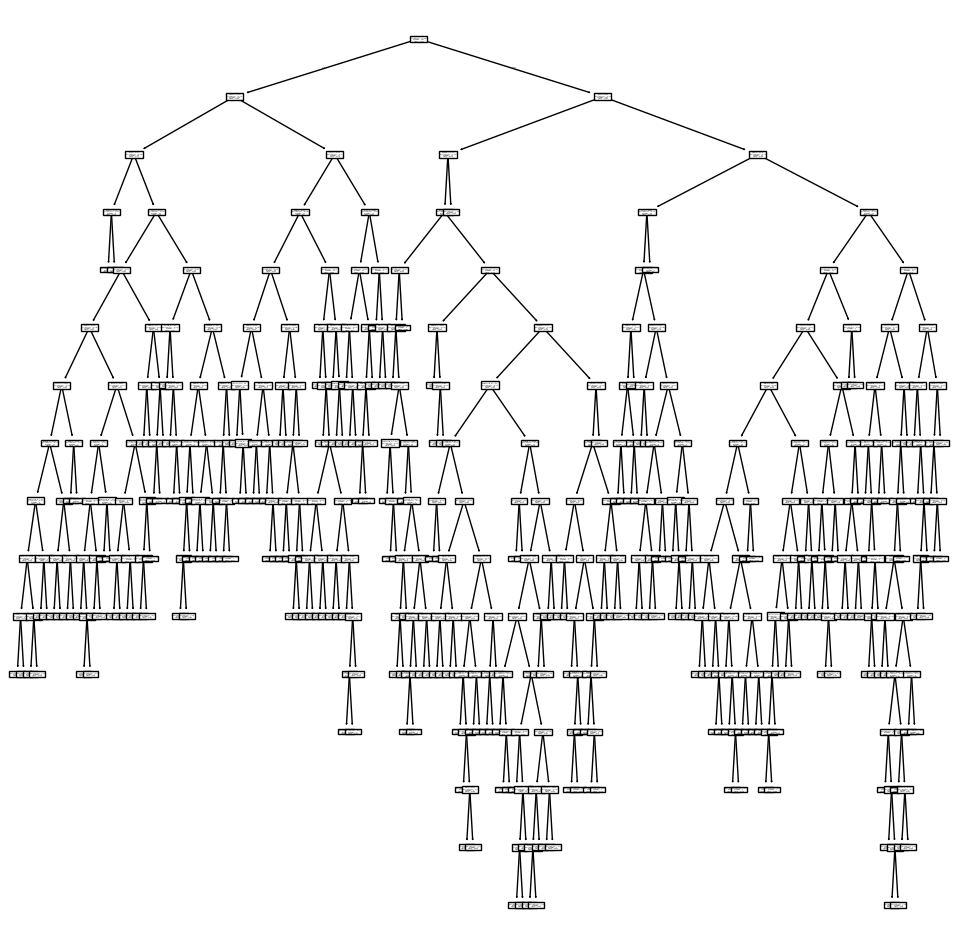

In [ ]:
# fit the decision tree
pipeline.fit(x, y)

# Get feature names after preprocessing
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_features = list(cat_features_encoded) + numerical_features

# Plot the decision tree
mod = pipeline.named_steps['model']
ax = subplots(figsize=(12,12))[1]
plot_tree(mod, feature_names=all_features, ax=ax);

Optimal ccp_alpha: {'ccp_alpha': 0.011672396763770956}
Test MSE: 0.22779378843346362


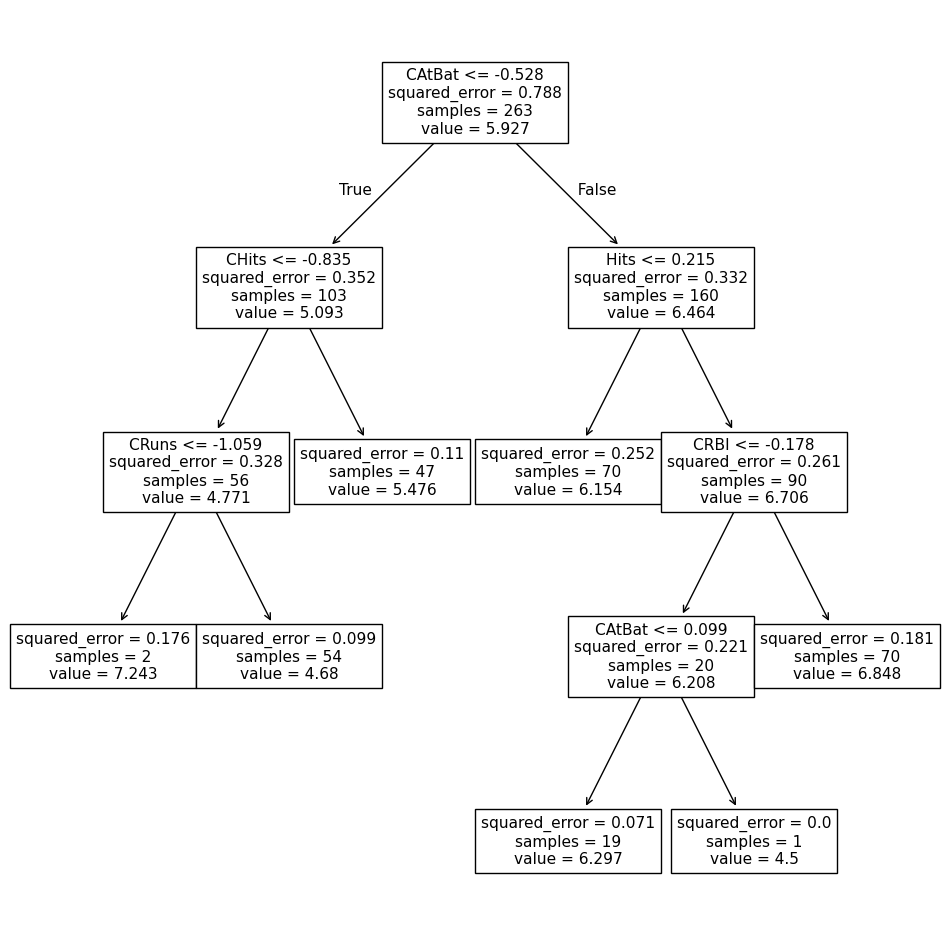

In [ ]:
# b: use LOOCV to determine optimal size of pruned tree

xt = preprocessor.fit_transform(x)
ccp_path = mod.cost_complexity_pruning_path(xt, y)
alpha = {'ccp_alpha': ccp_path.ccp_alphas}
grid = GridSearchCV(mod, alpha, refit=True, cv=loo, scoring='neg_mean_squared_error', error_score='raise')
G = grid.fit(xt, y)
print(f'Optimal ccp_alpha: {G.best_params_}')
print(f'Test MSE: {-G.best_score_}')

# plot decision tree
mod = G.best_estimator_
ax = subplots(figsize=(12,12))[1]
plot_tree(mod, feature_names=all_features, ax=ax);

In [ ]:
# c: use bagging approach with B = 1000

bagging_model = BR(estimator=DTR(criterion='squared_error'), n_estimators=1000, random_state=42)

# implement a pipeline
pipeline = Pipeline([('preprocessor', preprocessor),
    ('bagging', bagging_model)
])

# Use LOOCV
loo = LeaveOneOut()
scores = cross_val_score(pipeline, x, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')

# Calculate the MSE
mse = -scores.mean()
print(f'Test Mean Squared Error using LOOCV for Bagging: {mse}')


Test Mean Squared Error using LOOCV for Bagging: 0.19043527497365295


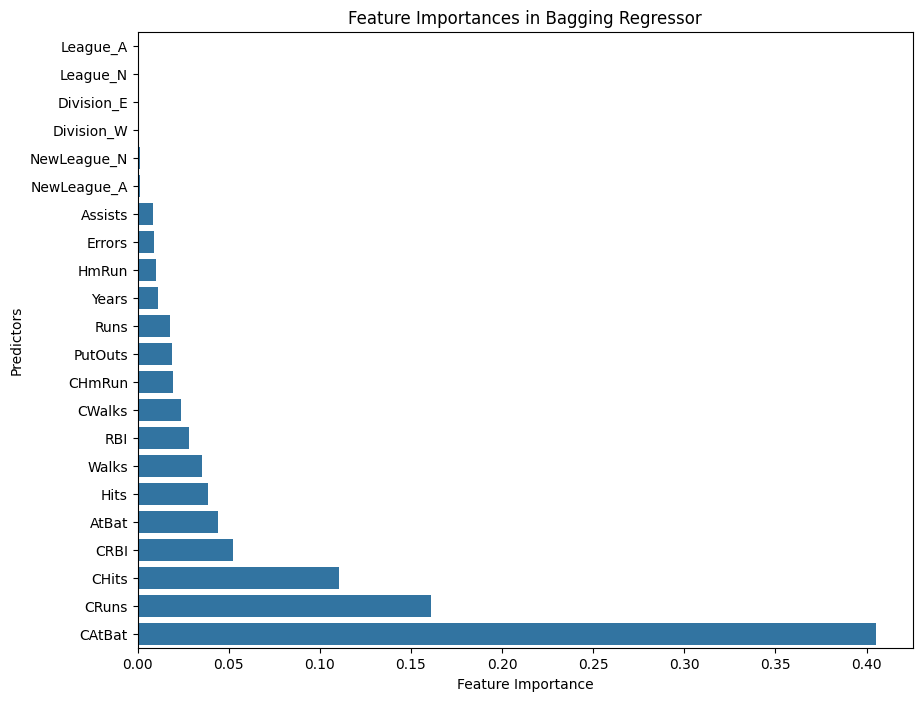

In [ ]:
# Fit the pipeline
pipeline.fit(x, y)

# Extract the trained GBR from the pipeline
trained_model = pipeline.named_steps['bagging']

# Extract feature importances from each base estimator
feature_importances = np.mean([
     tree.feature_importances_ for tree in trained_model.estimators_ ], axis=0)

# Get feature names from the preprocessor
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

# Sort the feature importances and names in ascending order
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=False)
sorted_feature_names = [name for name, importance in sorted_features]
sorted_importances = [importance for name, importance in sorted_features]

# Plot the feature importances as a bar graph
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y = sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Predictors')
plt.title('Feature Importances in Bagging Regressor')
plt.show()


In [ ]:
# d: random forest with B=1000 and m = p/3

rf_model = RF(n_estimators=1000, max_features=len(all_features)//3, random_state=42)

# implement a pipeline
pipeline = Pipeline([('preprocessor', preprocessor),
    ('rf', rf_model)
])

# Use LOOCV
loo = LeaveOneOut()
scores = cross_val_score(pipeline, x, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')

# Calculate the MSE
mse = -scores.mean()
print(f'Test Mean Squared Error using LOOCV for Random Forest: {mse}')



Test Mean Squared Error using LOOCV for Random Forest: 0.17977806511992467


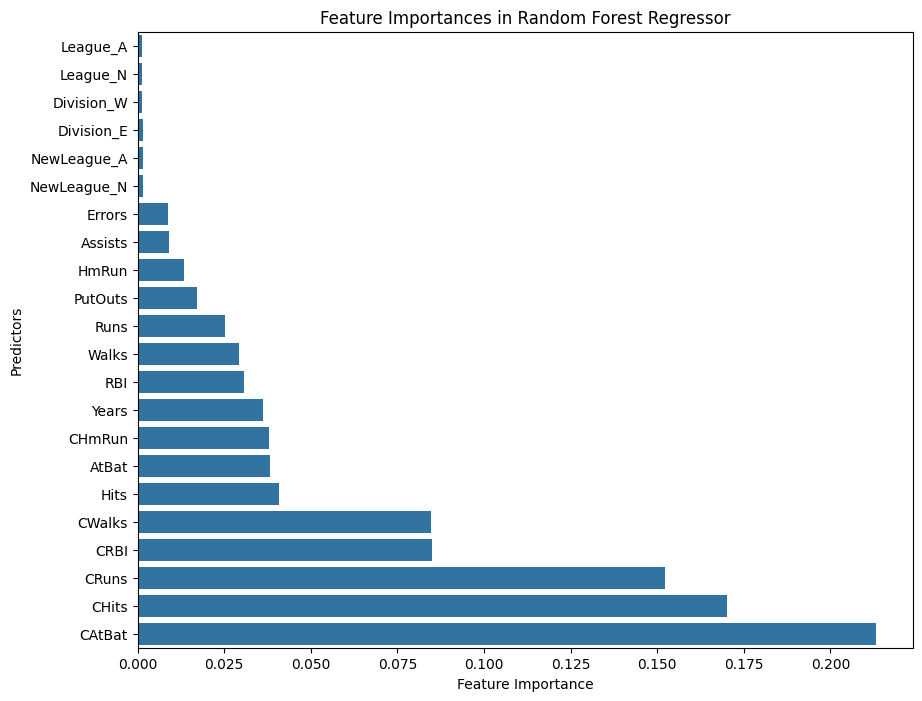

In [ ]:
# Fit the pipeline
pipeline.fit(x, y)

# Extract the trained GBR from the pipeline
trained_model = pipeline.named_steps['rf']

# Get the feature importances
feature_importances = trained_model.feature_importances_

# Get feature names from the preprocessor
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

# Sort the feature importances and names in ascending order
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=False)
sorted_feature_names = [name for name, importance in sorted_features]
sorted_importances = [importance for name, importance in sorted_features]

# Plot the feature importances as a bar graph
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y = sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Predictors')
plt.title('Feature Importances in Random Forest Regressor')
plt.show()


In [ ]:
# e: boosting approach with B = 1000, d = 1, lambda = 0.1

boost = GBR(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=42)

# a pipeline
pipeline = Pipeline([('preprocessor', preprocessor),
    ('gbr', boost)
])

# Use LOOCV
loo = LeaveOneOut()
scores = cross_val_score(pipeline, x, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')

# Calculate the MSE
mse = -scores.mean()
print(f'Test Mean Squared Error using LOOCV for Boosting: {mse}')



Test Mean Squared Error using LOOCV for Boosting: 0.18742644986595983


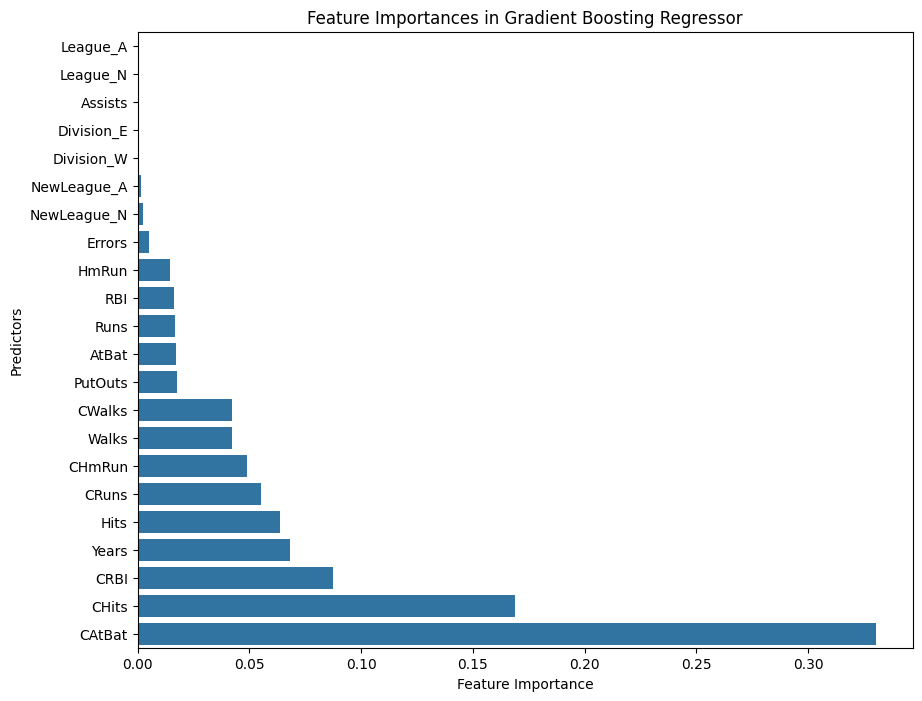

In [ ]:
# Fit the pipeline
pipeline.fit(x, y)

# Extract the trained GBR from the pipeline
trained_model = pipeline.named_steps['gbr']

# Get the feature importances
feature_importances = trained_model.feature_importances_

# Get feature names from the preprocessor
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

# Sort the feature importances and names in ascending order
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=False)
sorted_feature_names = [name for name, importance in sorted_features]
sorted_importances = [importance for name, importance in sorted_features]

# Plot the feature importances as a bar graph
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y = sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Predictors')
plt.title('Feature Importances in Gradient Boosting Regressor')
plt.show()


#### Problem 2


In [ ]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data if needed for compatibility with neural network layers
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# a: fit a neural network with 1 hidden layer with 512 hidden units and 5 epochs

# Build the neural network model
model = Sequential([ Flatten(input_shape=(28, 28, 1)),
                    Dense(512, activation='relu'),
                     Dense(10, activation='softmax')
                  ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8640 - loss: 0.4750 - val_accuracy: 0.9597 - val_loss: 0.1416
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9661 - loss: 0.1180 - val_accuracy: 0.9727 - val_loss: 0.0906
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9781 - loss: 0.0725 - val_accuracy: 0.9773 - val_loss: 0.0712
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9849 - loss: 0.0504 - val_accuracy: 0.9780 - val_loss: 0.0684
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9894 - loss: 0.0371 - val_accuracy: 0.9762 - val_loss: 0.0731
Training Error (Loss): 0.0297, Training Accuracy: 0.9919
Test Error (Loss): 0.0731, Test Accuracy: 0.9762


In [ ]:
# b: fit a neural network with 1 hidden layer with 512 hidden units and 10 epochs

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9932 - loss: 0.0261 - val_accuracy: 0.9816 - val_loss: 0.0590
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9948 - loss: 0.0207 - val_accuracy: 0.9794 - val_loss: 0.0649
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9963 - loss: 0.0151 - val_accuracy: 0.9818 - val_loss: 0.0579
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9974 - loss: 0.0117 - val_accuracy: 0.9800 - val_loss: 0.0648
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9977 - loss: 0.0097 - val_accuracy: 0.9804 - val_loss: 0.0614
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9980 - loss: 0.0080 - val_accuracy: 0.9802 - val_loss: 0.0710
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9974 - loss: 0.0085 - val_accuracy: 0.9830 - val_loss: 0.0618
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accur

In [ ]:
# c:  fit a neural network with 1 hidden layer with 256 hidden units and 5 epochs

# Build the neural network model
model = Sequential([ Flatten(input_shape=(28, 28, 1)),
                    Dense(256, activation='relu'),
                     Dense(10, activation='softmax')
                  ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8495 - loss: 0.5490 - val_accuracy: 0.9533 - val_loss: 0.1566
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9608 - loss: 0.1394 - val_accuracy: 0.9666 - val_loss: 0.1116
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9740 - loss: 0.0933 - val_accuracy: 0.9723 - val_loss: 0.0920
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9805 - loss: 0.0667 - val_accuracy: 0.9745 - val_loss: 0.0846
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9846 - loss: 0.0522 - val_accuracy: 0.9775 - val_loss: 0.0730
Training Error (Loss): 0.0381, Training Accuracy: 0.9895
Test Error (Loss): 0.0730, Test Accuracy: 0.9775


In [ ]:
 # d: fit a neural network with 1 hidden layer with 256 hidden units and 10 epochs

 # Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9902 - loss: 0.0362 - val_accuracy: 0.9787 - val_loss: 0.0719
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9907 - loss: 0.0323 - val_accuracy: 0.9791 - val_loss: 0.0681
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9938 - loss: 0.0243 - val_accuracy: 0.9789 - val_loss: 0.0657
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9956 - loss: 0.0191 - val_accuracy: 0.9796 - val_loss: 0.0647
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9968 - loss: 0.0157 - val_accuracy: 0.9793 - val_loss: 0.0690
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9975 - loss: 0.0121 - val_accuracy: 0.9798 - val_loss: 0.0706
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9976 - loss: 0.0110 - val_accuracy: 0.9793 - val_loss: 0.0670
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9986 - loss: 0.0080 - val_accuracy: 0.

In [ ]:
# e: fit a neural network with 2 hidden layer with 512 hidden units and 5 epochs

# Build the neural network model
model = Sequential([ Flatten(input_shape=(28, 28, 1)),
                    Dense(512, activation='relu'),
                     Dense(512, activation='relu'),
                     Dense(10, activation='softmax')
                  ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8843 - loss: 0.3967 - val_accuracy: 0.9670 - val_loss: 0.1038
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9758 - loss: 0.0797 - val_accuracy: 0.9722 - val_loss: 0.0846
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9832 - loss: 0.0510 - val_accuracy: 0.9698 - val_loss: 0.0956
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9880 - loss: 0.0356 - val_accuracy: 0.9773 - val_loss: 0.0724
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9918 - loss: 0.0248 - val_accuracy: 0.9797 - val_loss: 0.0766
Training Error (Loss): 0.0197, Training Accuracy: 0.9935
Test Error (Loss): 0.0766, Test Accuracy: 0.9797


In [ ]:
# f: fit a neural network with 2 hidden layer with 512 hidden units and 10 epochs

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9938 - loss: 0.0188 - val_accuracy: 0.9744 - val_loss: 0.0863
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9935 - loss: 0.0204 - val_accuracy: 0.9802 - val_loss: 0.0759
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9954 - loss: 0.0142 - val_accuracy: 0.9799 - val_loss: 0.0801
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9956 - loss: 0.0145 - val_accuracy: 0.9811 - val_loss: 0.0774
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9961 - loss: 0.0116 - val_accuracy: 0.9777 - val_loss: 0.0950
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9959 - loss: 0.0114 - val_accuracy: 0.9781 - val_loss: 0.0948
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9961 - loss: 0.0128 - val_accuracy: 0.9799 - val_loss: 0.0879
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9976 - loss: 0.0075 - val

In [ ]:
# g: fit a neural network with 2 hidden layer with 256 hidden units and 5 epochs

# Build the neural network model
model = Sequential([ Flatten(input_shape=(28, 28, 1)),
                    Dense(256, activation='relu'),
                     Dense(256, activation='relu'),
                     Dense(10, activation='softmax')
                  ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8629 - loss: 0.4806 - val_accuracy: 0.9627 - val_loss: 0.1185
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9710 - loss: 0.0998 - val_accuracy: 0.9710 - val_loss: 0.0873
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9801 - loss: 0.0643 - val_accuracy: 0.9782 - val_loss: 0.0770
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9866 - loss: 0.0425 - val_accuracy: 0.9755 - val_loss: 0.0778
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9902 - loss: 0.0327 - val_accuracy: 0.9776 - val_loss: 0.0740
Training Error (Loss): 0.0263, Training Accuracy: 0.9920
Test Error (Loss): 0.0740, Test Accuracy: 0.9776


In [ ]:
# h: fit a neural network with 2 hidden layer with 256 hidden units and 10 epochs

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9919 - loss: 0.0253 - val_accuracy: 0.9799 - val_loss: 0.0675
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9938 - loss: 0.0190 - val_accuracy: 0.9776 - val_loss: 0.0835
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9949 - loss: 0.0162 - val_accuracy: 0.9774 - val_loss: 0.0915
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9952 - loss: 0.0150 - val_accuracy: 0.9800 - val_loss: 0.0818
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9960 - loss: 0.0118 - val_accuracy: 0.9779 - val_loss: 0.0989
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9954 - loss: 0.0135 - val_accuracy: 0.9784 - val_loss: 0.0844
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9979 - loss: 0.0065 - val_accuracy: 0.9804 - val_loss: 0.0884
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9959 - loss: 0.0127 - val_accuracy: 

In [ ]:
# L2 weight regularization lambda=0.001

# Build the neural network model
model = Sequential([ Flatten(input_shape=(28, 28, 1)),
                    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
                     Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
                  ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8657 - loss: 0.8245 - val_accuracy: 0.9526 - val_loss: 0.3352
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9536 - loss: 0.3151 - val_accuracy: 0.9597 - val_loss: 0.2762
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9623 - loss: 0.2733 - val_accuracy: 0.9635 - val_loss: 0.2646
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9649 - loss: 0.2627 - val_accuracy: 0.9661 - val_loss: 0.2593
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9670 - loss: 0.2570 - val_accuracy: 0.9673 - val_loss: 0.2547
Training Error (Loss): 0.2477, Training Accuracy: 0.9715
Test Error (Loss): 0.2547, Test Accuracy: 0.9673


In [ ]:
# j: fit neural network with 50% dropout

# Build the neural network model
model = Sequential([ Flatten(input_shape=(28, 28, 1)),
                    Dense(512, activation='relu'), Dropout(0.5),
                     Dense(10, activation='softmax')
                  ])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Report training and test errors
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Training Error (Loss): {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Error (Loss): {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8365 - loss: 0.5540 - val_accuracy: 0.9553 - val_loss: 0.1486
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9504 - loss: 0.1706 - val_accuracy: 0.9670 - val_loss: 0.1057
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9630 - loss: 0.1265 - val_accuracy: 0.9721 - val_loss: 0.0892
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9699 - loss: 0.1013 - val_accuracy: 0.9735 - val_loss: 0.0875
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9742 - loss: 0.0850 - val_accuracy: 0.9782 - val_loss: 0.0712
Training Error (Loss): 0.0443, Training Accuracy: 0.9874
Test Error (Loss): 0.0712, Test Accuracy: 0.9782


#### Problem 3

In [5]:
# load the data

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

# preparing the data
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std
x_test -= mean
x_test /= std


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 - 1s - 74ms/step - loss: 21.5498 - mae: 21.5498 - val_loss: 18.6299 - val_mae: 18.6299
Epoch 2/200
19/19 - 0s - 4ms/step - loss: 18.9132 - mae: 18.9132 - val_loss: 15.5306 - val_mae: 15.5306
Epoch 3/200
19/19 - 0s - 8ms/step - loss: 14.4803 - mae: 14.4803 - val_loss: 10.7204 - val_mae: 10.7204
Epoch 4/200
19/19 - 0s - 7ms/step - loss: 9.0925 - mae: 9.0925 - val_loss: 7.1573 - val_mae: 7.1573
Epoch 5/200
19/19 - 0s - 8ms/step - loss: 6.7220 - mae: 6.7220 - val_loss: 5.9144 - val_mae: 5.9144
Epoch 6/200
19/19 - 0s - 5ms/step - loss: 5.1983 - mae: 5.1983 - val_loss: 4.7336 - val_mae: 4.7336
Epoch 7/200
19/19 - 0s - 7ms/step - loss: 4.2138 - mae: 4.2138 - val_loss: 3.9542 - val_mae: 3.9542
Epoch 8/200
19/19 - 0s - 5ms/step - loss: 3.6518 - mae: 3.6518 - val_loss: 3.7238 - val_mae: 3.7238
Epoch 9/200
19/19 - 0s - 7ms/step - loss: 3.4308 - mae: 3.4308 - val_loss: 3.5677 - val_mae: 3.5677
Epoch 10/200
19/19 - 0s - 5ms/step - loss: 3.3036 - mae: 3.3036 - val_loss: 3.4151 - val_mae: 3.415

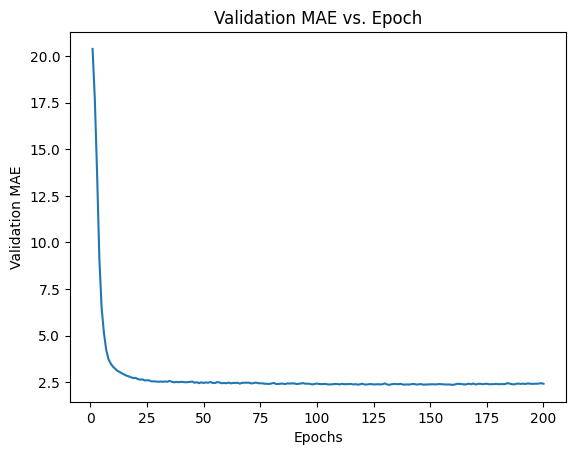

Recommended number of epochs: 75
Epoch 1/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.0928 - mae: 22.0928 - val_loss: 20.9139 - val_mae: 20.9139
Epoch 2/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.5355 - mae: 19.5355 - val_loss: 16.3313 - val_mae: 16.3313
Epoch 3/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.8150 - mae: 13.8150 - val_loss: 9.5099 - val_mae: 9.5099
Epoch 4/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3389 - mae: 7.3389 - val_loss: 6.7678 - val_mae: 6.7678
Epoch 5/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1920 - mae: 5.1920 - val_loss: 5.1951 - val_mae: 5.1951
Epoch 6/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2008 - mae: 4.2008 - val_loss: 4.4410 - val_mae: 4.4410
Epoch 7/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3785 - mae: 3.3785 - val_loss: 3.9439 - val_mae: 3.9439
Epoch 8/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0697 - mae: 3.0697 - val_loss: 3.6860 - val_mae: 3.6860
Epoch 9/75
26/26 ━━━━━━━━━━━━

In [7]:
 # a: Fit a neural network with 2 hidden layers, 64 hidden units, and 200 epochs

# Define the neural network model
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)  # No activation for regression
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


# 4-Fold Cross Validation

kf = KFold(n_splits=4, shuffle=True, random_state=42)
val_mae_per_epoch = []
for train_index, val_index in kf.split(x_train):
    x_train_kf, x_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    model = build_model()
    history = model.fit(x_train_kf, y_train_kf, epochs=200, batch_size=16, validation_data=(x_val_kf, y_val_kf), verbose=2)
    val_mae_per_epoch.append(history.history['val_mae'])

# Calculate mean validation MAE per epoch
mean_val_mae_per_epoch = np.mean(val_mae_per_epoch, axis=0)

# Plot validation MAE against epoch
plt.plot(range(1, 201), mean_val_mae_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs. Epoch')
plt.show()

# early stopping based on the plot
recommended_epochs = 75
print(f"Recommended number of epochs: {recommended_epochs}")

# Fit the model with the suggested number of epochs
model = build_model()
model.fit(x_train, y_train, epochs=recommended_epochs, batch_size=16, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f"Validation MAE with suggested epochs: {test_mae:.4f}")


In [10]:
# b: Fit a neural network model with 1 hidden layer with 128 units. Report its validation MAE.

# Define the neural network model
def build_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
        Dense(1)  # No activation for regression
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

# Fit the model with the suggested number of epochs
model = build_model()
model.fit(x_train, y_train, epochs=recommended_epochs, batch_size=16, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f"Validation MAE with suggested epochs: {test_mae:.4f}")

Epoch 1/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 23.2027 - mae: 23.2027 - val_loss: 22.6574 - val_mae: 22.6574
Epoch 2/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9184 - mae: 21.9184 - val_loss: 21.3670 - val_mae: 21.3670
Epoch 3/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.4758 - mae: 20.4758 - val_loss: 19.7121 - val_mae: 19.7121
Epoch 4/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.3779 - mae: 18.3779 - val_loss: 17.6292 - val_mae: 17.6292
Epoch 5/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.8210 - mae: 15.8210 - val_loss: 15.4172 - val_mae: 15.4172
Epoch 6/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.4185 - mae: 13.4185 - val_loss: 12.8928 - val_mae: 12.8928
Epoch 7/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.9704 - mae: 10.9704 - val_loss: 10.5932 - val_mae: 10.5932
Epoch 8/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0233 - mae: 9.0233 - val_loss: 8.8445 - val_mae: 8.8445
Epoch 9/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

In [11]:
# c: L2 weight regularization to the model with 2 hidden layers, each with 64 hidden units. Report its validation MAE.

# Define the neural network model
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)  # No activation for regression
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

# Fit the model with the suggested number of epochs
model = build_model()
model.fit(x_train, y_train, epochs=recommended_epochs, batch_size=16, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f"Validation MAE with suggested epochs: {test_mae:.4f}")

Epoch 1/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21.2828 - mae: 21.1958 - val_loss: 19.7982 - val_mae: 19.7093
Epoch 2/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.5204 - mae: 17.4299 - val_loss: 14.6007 - val_mae: 14.5041
Epoch 3/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.9626 - mae: 11.8633 - val_loss: 8.4888 - val_mae: 8.3815
Epoch 4/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2447 - mae: 7.1359 - val_loss: 6.3584 - val_mae: 6.2468
Epoch 5/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0023 - mae: 4.8906 - val_loss: 4.7087 - val_mae: 4.5964
Epoch 6/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9571 - mae: 3.8445 - val_loss: 4.1452 - val_mae: 4.0325
Epoch 7/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2992 - mae: 3.1862 - val_loss: 3.9713 - val_mae: 3.8589
Epoch 8/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2609 - mae: 3.1486 - val_loss: 3.7478 - val_mae: 3.6360
Epoch 9/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.96

In [12]:
# d: Add L2 weight regularization to the model with 1 hidden layer with 128 hidden units. Report its validation MAE.

# Define the neural network model
def build_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.001)),
        Dense(1)  # No activation for regression
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

# Fit the model with the suggested number of epochs
model = build_model()
model.fit(x_train, y_train, epochs=recommended_epochs, batch_size=16, validation_data=(x_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f"Validation MAE with suggested epochs: {test_mae:.4f}")

Epoch 1/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.2143 - mae: 22.1908 - val_loss: 21.8566 - val_mae: 21.8326
Epoch 2/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.9322 - mae: 20.9079 - val_loss: 20.4121 - val_mae: 20.3863
Epoch 3/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.9006 - mae: 18.8740 - val_loss: 18.5845 - val_mae: 18.5551
Epoch 4/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.6254 - mae: 16.5949 - val_loss: 16.4326 - val_mae: 16.3982
Epoch 5/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.3419 - mae: 15.3060 - val_loss: 13.8472 - val_mae: 13.8063
Epoch 6/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.3823 - mae: 12.3395 - val_loss: 11.4186 - val_mae: 11.3700
Epoch 7/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5292 - mae: 9.4788 - val_loss: 9.5394 - val_mae: 9.4844
Epoch 8/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0973 - mae: 8.0408 - val_loss: 8.2090 - val_mae: 8.1490
Epoch 9/75
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste